# Import libraries from flow relevent to the simulation:

In [1]:
from flow.controllers import GridRouter
from flow.core.params import SumoParams, EnvParams, InitialConfig, NetParams
from flow.core.params import VehicleParams
from flow.core.params import TrafficLightParams
from flow.core.params import SumoCarFollowingParams
from flow.core.params import InFlows
from flow.envs.traffic_light_grid import ADDITIONAL_ENV_PARAMS
from flow.envs import TrafficLightGridGenericObserver
from flow.networks import TrafficLightGridNetwork

from flow.core.experiment import Experiment

from signal_control.Testing.TrafficGrid_utils import *

# Add observation:

## Initialize simulation environment parameters:

In [66]:
# Define gemoetries of the network:
v_enter = 10
inner_length = 300 # length of inner road lengths
long_length = 500
short_length = 500

# Defines rows and columns:
n_rows = 1
n_columns = 5


num_cars_left = 0
num_cars_right = 0
num_cars_top = 0
num_cars_bot = 0
tot_cars = (num_cars_left + num_cars_right) * n_columns \
           + (num_cars_top + num_cars_bot) * n_rows

grid_array = {
    "short_length": short_length,
    "inner_length": inner_length,
    "long_length": long_length,
    "row_num": n_rows,
    "col_num": n_columns,
    "cars_left": num_cars_left,
    "cars_right": num_cars_right,
    "cars_top": num_cars_top,
    "cars_bot": num_cars_bot
}


def gen_edges(col_num, row_num):
    """Generate the names of the outer edges in the grid network.

    Parameters
    ----------
    col_num : int
        number of columns in the grid
    row_num : int
        number of rows in the grid

    Returns
    -------
    list of str
        names of all the outer edges
    """
    edges = []

    # build the left and then the right edges
    for i in range(col_num):
        edges += ['left' + str(row_num) + '_' + str(i)]
        edges += ['right' + '0' + '_' + str(i)]

    # build the bottom and then top edges
    for i in range(row_num):
        edges += ['bot' + str(i) + '_' + '0']
        edges += ['top' + str(i) + '_' + str(col_num)]

    return edges


def get_flow_params(col_num, row_num, additional_net_params,main_flow,arterial_flow):
    """Define the network and initial params in the presence of inflows.

    Parameters
    ----------
    col_num : int
        number of columns in the grid
    row_num : int
        number of rows in the grid
    additional_net_params : dict
        network-specific parameters that are unique to the grid

    Returns
    -------
    flow.core.params.InitialConfig
        parameters specifying the initial configuration of vehicles in the
        network
    flow.core.params.NetParams
        network-specific parameters used to generate the network
    """
    initial = InitialConfig(
        spacing='custom', lanes_distribution=float('inf'), shuffle=True)

    inflow = InFlows()
    outer_edges = gen_edges(col_num, row_num)
    for i in range(len(outer_edges)):
        edge_id = outer_edges[i]
        if('top' in edge_id):
            inflow.add(
                veh_type='human',
                edge=edge_id,
                vehs_per_hour=main_flow,
                depart_lane='free',
                depart_speed=20)
        else:
            inflow.add(
                veh_type='human',
                edge=edge_id,
                vehs_per_hour=arterial_flow,
                depart_lane='free',
                depart_speed=20)

    net = NetParams(
        inflows=inflow,
        additional_params=additional_net_params)

    return initial, net


def get_non_flow_params(enter_speed, add_net_params):
    """Define the network and initial params in the absence of inflows.

    Note that when a vehicle leaves a network in this case, it is immediately
    returns to the start of the row/column it was traversing, and in the same
    direction as it was before.

    Parameters
    ----------
    enter_speed : float
        initial speed of vehicles as they enter the network.
    add_net_params: dict
        additional network-specific parameters (unique to the grid)

    Returns
    -------
    flow.core.params.InitialConfig
        parameters specifying the initial configuration of vehicles in the
        network
    flow.core.params.NetParams
        network-specific parameters used to generate the network
    """
    additional_init_params = {'enter_speed': enter_speed}
    initial = InitialConfig(
        spacing='custom', additional_params=additional_init_params)
    net = NetParams(additional_params=add_net_params)

    return initial, net


###### VEHICLES: ######

vehicles = VehicleParams()
vehicles.add(
    veh_id="human",
    routing_controller=(GridRouter, {}),
    car_following_params=SumoCarFollowingParams(
        min_gap=2.5,
        decel=7.5,  # avoid collisions at emergency stops
    ),
    num_vehicles=tot_cars)


###### STATIC TL PHASES: ######

# Unsure to what extent this is working...

tl_logic = TrafficLightParams(baseline=False)

phases = [{"duration": "10", "state": "GrGr"},
          {"duration": "5", "state": "yryr"},
          {"duration": "20", "state": "rGrG"},
          {"duration": "5", "state": "ryry"}]

for i in range(n_columns):

    tl_logic.add("center"+str(i), phases=phases, tls_type="static", programID="1", offset=None)

additional_net_params = {
    "grid_array": grid_array,
    "speed_limit": 35,
    "horizontal_lanes": 1,
    "vertical_lanes": 1
}


###### FLOW RATES: ######


MAIN_FLOW = 1000
ARTERIAL_FLOW = 200


initial_config, net_params = get_flow_params(
    col_num=n_columns,
    row_num=n_rows,
    additional_net_params=additional_net_params,
    main_flow=MAIN_FLOW,
    arterial_flow=ARTERIAL_FLOW)

print('Defined simulation parameters.')

Defined simulation parameters.


## Define an observer:

In [3]:
import numpy as np

# NOTE: an observer function takes in the env object and should return a state calculated on that environment.

# In this case the observer returns vehicular counts on every edge.


def observer_counts(env):
    
    edge_ids = env.k.network.get_edge_list()

    counts = dict.fromkeys(edge_ids)
    
    for edge_id in edge_ids:
        # How many veh_ids are on each edge is the count:
        ids_by_edge = env.k.vehicle.get_ids_by_edge(edge_id)
        counts[edge_id] = len(ids_by_edge)
    
    edge_counts = []
    for edge_id in edge_ids:
        edge_counts.append(counts[edge_id])
    
#     print(edge_counts)
    
    return np.array(edge_counts)



In [4]:
# An observer function is passed to the environment through additional_env_params:
ADDITIONAL_ENV_PARAMS['observer'] = observer_counts


# These aren't important for this example, additional sim parameters:

ADDITIONAL_ENV_PARAMS['tl_type'] = 'static'
ADDITIONAL_ENV_PARAMS['num_observed'] = 1
ADDITIONAL_ENV_PARAMS['target_velocity'] = 15
print(ADDITIONAL_ENV_PARAMS['tl_type'])

static


In [5]:
HORIZON = 500 # Number of simulation steps to be performed.

flow_params = dict(
    # name of the experiment
    exp_tag='traffic_light_grid',

    # name of the flow environment the experiment is running on
    env_name=TrafficLightGridGenericObserver,

    # name of the network class the experiment is running on
    network=TrafficLightGridNetwork,

    # simulator that is used by the experiment
    simulator='traci',

    # sumo-related parameters (see flow.core.params.SumoParams)
    sim=SumoParams(
        sim_step=0.5,
        render=True, # For no rendering set to False
    ),

    # environment related parameters (see flow.core.params.EnvParams)
    env=EnvParams(
        horizon=HORIZON,
        additional_params=ADDITIONAL_ENV_PARAMS.copy(),
    ),

    # network-related parameters (see flow.core.params.NetParams and the
    # network's documentation or ADDITIONAL_NET_PARAMS component). This is
    # filled in by the setup_exps method below.
    net=net_params,

    # vehicles to be placed in the network at the start of a rollout (see
    # flow.core.params.VehicleParams)
    veh=vehicles,

    # parameters specifying the positioning of vehicles upon initialization/
    # reset (see flow.core.params.InitialConfig). This is filled in by the
    # setup_exps method below.
    initial=initial_config,

    # traffic lights to be introduced to specific nodes (see
    # flow.core.params.TrafficLightParams)
    tls=tl_logic,
)



In [6]:
exp = Experiment(flow_params)

In [10]:
info_dict = exp.run(num_runs=1)

**********************************************************
**********************************************************
**********************************************************
significantly decrease after large number of rollouts. In 
order to avoid this, set SumoParams(restart_instance=True).
**********************************************************
**********************************************************
**********************************************************
Round 0, return: 0
Total time: 67.59567093849182
steps/second: 52.94518569337916


In [12]:
states = info_dict['states']

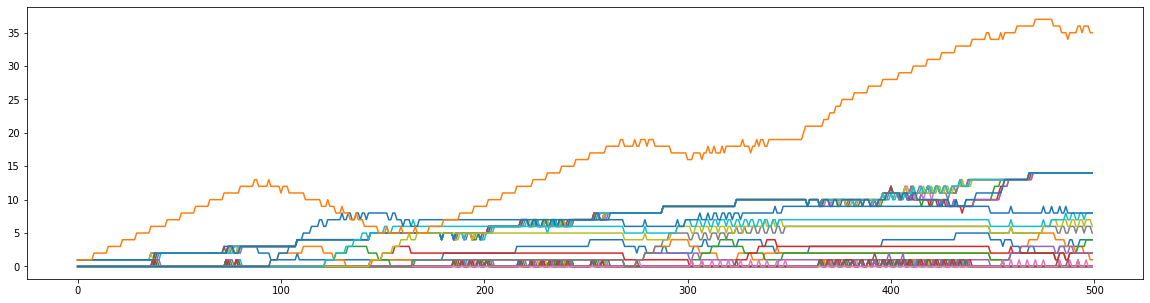

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,5])

_ = plt.plot(np.array(states))

In [17]:
exp.env.get_state()

array([ 4,  1,  4,  2,  2,  0,  0,  0,  0,  0,  0, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14,  0,  0,  0,  0,  0,  0,  5,  6,  8,  8, 35])

## Look at more in depth observation:

In [79]:
def observer_ave_veh_speed_edgewise(env):
    
    edge_ids = env.k.network.get_edge_list()
    
    vehicular_speeds_by_edge = {}
    
    for edge_id in edge_ids:
        # How many veh_ids are on each edge is the count:
        ids_by_edge = env.k.vehicle.get_ids_by_edge(edge_id)
        
        veh_speeds = []
        
        if(len(ids_by_edge) == 0):
            veh_speeds.append(30.0)
        else:
            for veh_id in ids_by_edge:
                current_veh_speed = env.k.vehicle.get_speed(veh_id)
                veh_speeds.append(current_veh_speed)
                
        vehicular_speeds_by_edge[edge_id] = np.mean(veh_speeds)
        
    ave_veh_speeds = []
    for edge_id in edge_ids:
        ave_veh_speeds.append(vehicular_speeds_by_edge[edge_id])
        
    return ave_veh_speeds

# observer_ave_veh_speed_edgewise(exp.env)

In [78]:
def observer_ave_veh_speed_counts_tl_states(env):
    
    edge_ids = env.k.network.get_edge_list()
    
    vehicular_speeds_by_edge = {}
    
    for edge_id in edge_ids:
        # How many veh_ids are on each edge is the count:
        ids_by_edge = env.k.vehicle.get_ids_by_edge(edge_id)
        
        veh_speeds = []
        
        if(len(ids_by_edge) == 0):
            veh_speeds.append(30.0)
        else:
            for veh_id in ids_by_edge:
                current_veh_speed = env.k.vehicle.get_speed(veh_id)
                veh_speeds.append(current_veh_speed)
                
        vehicular_speeds_by_edge[edge_id] = np.mean(veh_speeds)
        
    ave_veh_speeds = []
    for edge_id in edge_ids:
        ave_veh_speeds.append(vehicular_speeds_by_edge[edge_id])
        
    
    edge_ids = env.k.network.get_edge_list()

    counts = dict.fromkeys(edge_ids)
    
    for edge_id in edge_ids:
        # How many veh_ids are on each edge is the count:
        ids_by_edge = env.k.vehicle.get_ids_by_edge(edge_id)
        counts[edge_id] = len(ids_by_edge)
    
    edge_counts = []
    for edge_id in edge_ids:
        edge_counts.append(counts[edge_id])
    
    traffic_light_ids = env.k.traffic_light.get_ids()
    traffic_light_states = []
    for tl_id in traffic_light_ids:
        traffic_light_states.append(env.k.traffic_light.get_state(tl_id))
        
        
    return [edge_counts,ave_veh_speeds,traffic_light_states]



def get_state_timeseries(states):
    all_counts = []
    all_speeds = []
    all_tl_states = []

    for state in states:
        counts = state[0]
        speeds = state[1]
        tl_states = state[2]

        all_counts.append(counts)
        all_speeds.append(speeds)
        all_tl_states.append(tl_states)
        
    return all_counts,all_speeds,all_tl_states


def numerical_tl_states(tl_states):
    tl_states_numerical = []
    
    state_1 = 'rGrG'
    state_2 = 'ryry'
    state_3 = 'GrGr'
    state_4 = 'yryr'
    
    for tl_state in tl_states:
        curr_num_state = []
        for i in range(len(tl_state)):
            if(tl_state[i] == state_1):
                curr_num_state.append(1)
            elif(tl_state[i] == state_2):
                curr_num_state.append(2)
            elif(tl_state[i] == state_3):
                curr_num_state.append(3)
            elif(tl_state[i] == state_4):
                curr_num_state.append(4)
                
        tl_states_numerical.append(curr_num_state)
        
    return tl_states_numerical

In [91]:
ADDITIONAL_ENV_PARAMS['observer'] = observer_ave_veh_speed_counts_tl_states
ADDITIONAL_ENV_PARAMS['tl_type'] = 'static'

In [120]:
HORIZON = 1000 # Number of simulation steps to be performed.



###### STATIC TL PHASES: ######

# Unsure to what extent this is working...

tl_logic = TrafficLightParams(baseline=False)

phases = [{"duration": "50", "state": "rGrG"},
          {"duration": "5", "state": "ryry"},
          {"duration": "10", "state": "GrGr"},
          {"duration": "5", "state": "yryr"}]

for i in range(1,n_columns):

    tl_logic.add("center"+str(i), phases=phases, tls_type="static", programID="1", offset=None)

# Add a fast light at the boundary:
    
phase_boundary = [{"duration": "10", "state": "rGrG"},
          {"duration": "5", "state": "ryry"},
          {"duration": "10", "state": "GrGr"},
          {"duration": "5", "state": "yryr"}]

tl_logic.add("center"+str(0), phases=phase_boundary, tls_type="static", programID="1", offset=None)



flow_params = dict(
    # name of the experiment
    exp_tag='traffic_light_grid',

    # name of the flow environment the experiment is running on
    env_name=TrafficLightGridGenericObserver,

    # name of the network class the experiment is running on
    network=TrafficLightGridNetwork,

    # simulator that is used by the experiment
    simulator='traci',

    # sumo-related parameters (see flow.core.params.SumoParams)
    sim=SumoParams(
        sim_step=0.5,
        render=True, # For no rendering set to False
    ),

    # environment related parameters (see flow.core.params.EnvParams)
    env=EnvParams(
        horizon=HORIZON,
        additional_params=ADDITIONAL_ENV_PARAMS.copy(),
    ),

    # network-related parameters (see flow.core.params.NetParams and the
    # network's documentation or ADDITIONAL_NET_PARAMS component). This is
    # filled in by the setup_exps method below.
    net=net_params,

    # vehicles to be placed in the network at the start of a rollout (see
    # flow.core.params.VehicleParams)
    veh=vehicles,

    # parameters specifying the positioning of vehicles upon initialization/
    # reset (see flow.core.params.InitialConfig). This is filled in by the
    # setup_exps method below.
    initial=initial_config,
    
    # traffic lights to be introduced to specific nodes (see
    # flow.core.params.TrafficLightParams)
    tls=tl_logic,
)

exp = Experiment(flow_params)

info_dict = exp.run(num_runs=1)



**********************************************************
**********************************************************
**********************************************************
significantly decrease after large number of rollouts. In 
order to avoid this, set SumoParams(restart_instance=True).
**********************************************************
**********************************************************
**********************************************************
Round 0, return: 0
Total time: 52.94058394432068
steps/second: 56.20340267396308


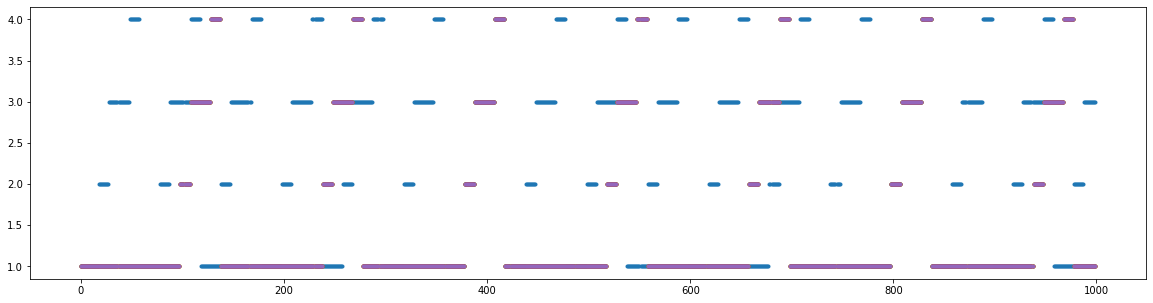

In [119]:
states = info_dict['states']

all_counts,all_speeds,all_tl_states = get_state_timeseries(states)

tl_states_numerical = numerical_tl_states(all_tl_states)

plt.figure(figsize=[20,5])
_ = plt.plot(tl_states_numerical,'.')

In [95]:
states = info_dict['states']

In [96]:
print(states[0][2])

['rGrG', 'rGrG', 'rGrG', 'rGrG', 'rGrG']


In [97]:
all_counts,all_speeds,all_tl_states = get_state_timeseries(states)

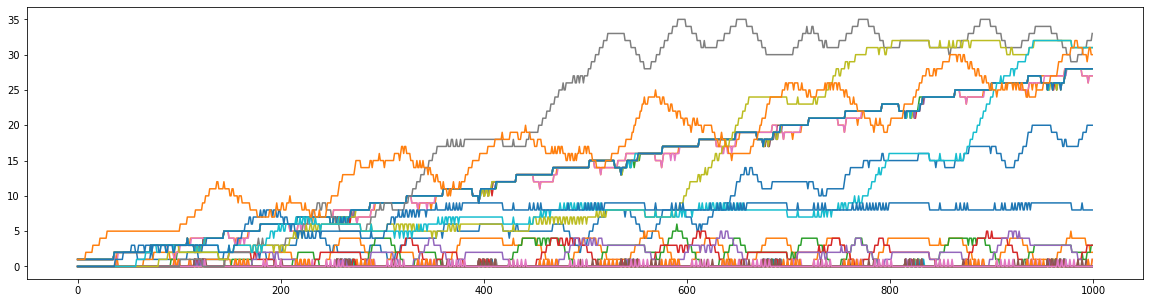

In [114]:
plt.figure(figsize=[20,5])
_ = plt.plot(all_counts)

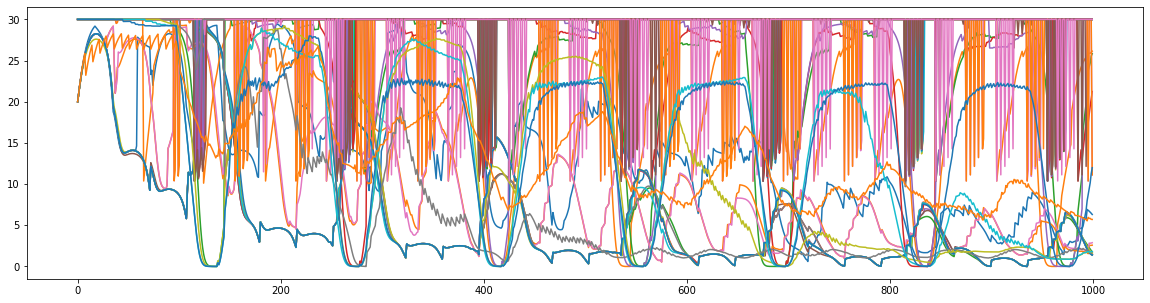

In [115]:
plt.figure(figsize=[20,5])
_ = plt.plot(all_speeds)

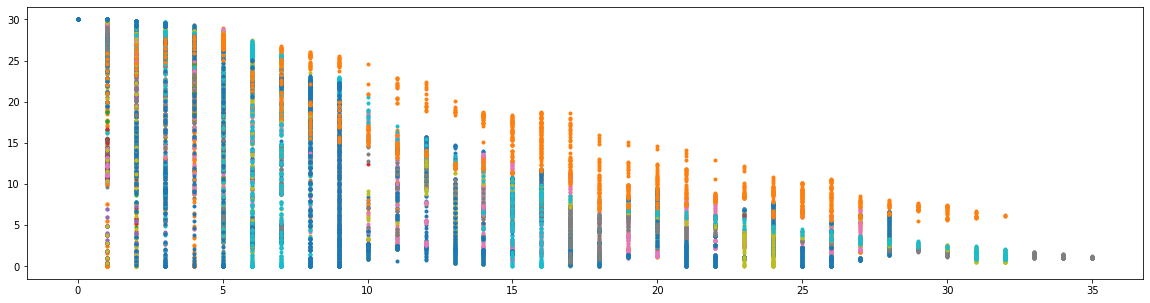

In [116]:
plt.figure(figsize=[20,5])
_ = plt.plot(all_counts,all_speeds,'.')

In [100]:
tl_states_numerical = numerical_tl_states(all_tl_states)

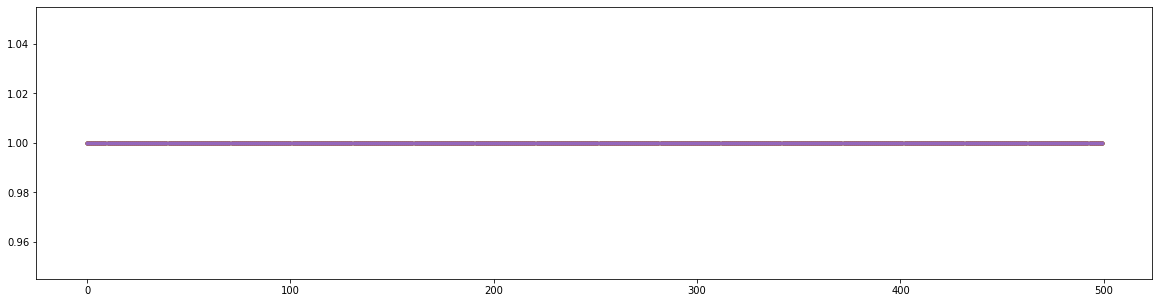

In [101]:
plt.figure(figsize=[20,5])
_ = plt.plot(tl_states_numerical,'.')